# KeyboardDetection

This code was __abandoned__ since using traditional CV should not be the main idea of this project because of its week robustness and difficulty of implementation.

Last Updated on Apr 9, 2019

In [1]:
import copy
import cv2
import matplotlib.pyplot as plt
import skimage
import numpy as np
import imageio
import random
import math

import my_utils
import dataset

Load all file locations ...
Training Dataset: 71 videos.
Testing Dataset: 10 videos.


(360, 640)


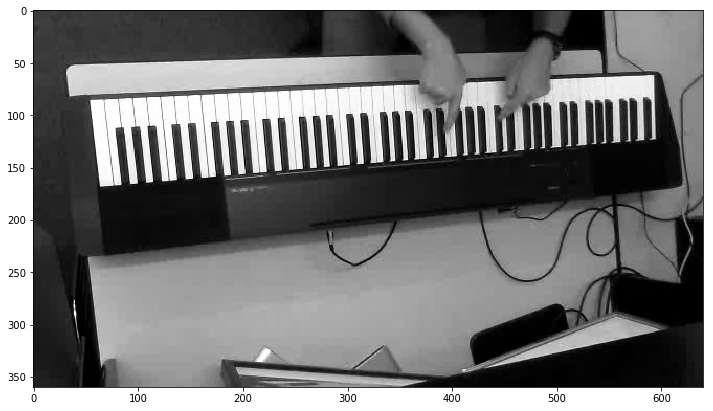

In [2]:
# Load an arbitrary frame of some training video

cap = cv2.VideoCapture(dataset.train_videos[22])
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
cap.set(cv2.CAP_PROP_POS_FRAMES, 355)
res, frame = cap.read()
origin_file = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# frame = cv2.imread('test.jpg')
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# backup of the original image

# display image size and content
print(frame.shape)
plt.figure(figsize=(12, 24))
plt.imshow(frame, cmap=plt.get_cmap('gray'))

# save image
imageio.imwrite('stage_1.jpg', frame)

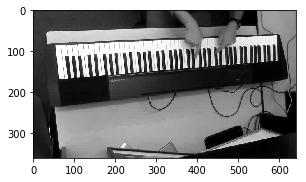

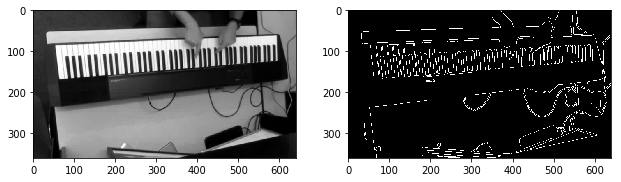

In [3]:
# Conny Process

# retval, frame = cv2.threshold(frame, 0, 255, cv2.THRESH_OTSU)
plt.figure(figsize=(16, 32))
plt.subplot(1, 3, 1)
plt.imshow(frame, cmap=plt.get_cmap('gray'))

# save image
imageio.imwrite('stage_2.jpg', frame)

blur = cv2.GaussianBlur(frame, (3, 3), 0)
plt.figure(figsize=(16, 32))
plt.subplot(1, 3, 2)
plt.imshow(blur, cmap=plt.get_cmap('gray'))

# save image
imageio.imwrite('stage_3.jpg', blur)

edges = cv2.Canny(blur, 100, 200)
plt.subplot(1, 3, 3)
plt.imshow(edges, cmap=plt.get_cmap('gray'))

# save image
imageio.imwrite('stage_4.jpg', edges)

In [4]:
# Display lines on a image

def display_lines(src_image, lines_arr, file_name, option=None):
    image = copy.copy(src_image)
    if option:
        image = cv2.cvtColor(image, option)
    for rho, theta in lines_arr:
        det_x = np.cos(theta)
        det_y = np.sin(theta)
        x0 = rho * det_x
        y0 = rho * det_y
        x1 = (int)(x0 - 10000 * det_y)
        y1 = (int)(y0 + 10000 * det_x)
        x2 = (int)(x0 + 10000 * det_y)
        y2 = (int)(y0 - 10000 * det_x)
        cv2.line(image, (x1, y1), (x2, y2), 
                 (random.randint(0, 256), random.randint(0, 256), random.randint(0, 256)), 2)
    plt.figure(figsize = (12, 24))
    plt.imshow(image)
    
    # save image
    imageio.imwrite(file_name, image)

In [5]:
# Hough Line Detections

lines = cv2.HoughLines(edges, 1, np.pi / 360.0, 120)
lines = lines[:, 0, :]

# Sort by theta
lines = sorted(lines, key=lambda x: x[1])

print('# of lines found: %d' % len(lines))

# of lines found: 22


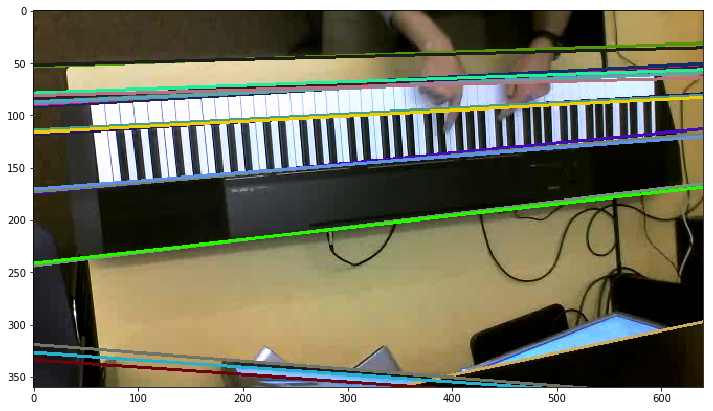

In [6]:
# Put detected lines on the original image

display_lines(origin_file, lines, 'stage_5.jpg')

In [7]:
class union_set:
    def __init__(self, _n):
        self.fa = list(range(_n))
        self.size = _n
    
    def find(self, x):
        if self.fa[x] == x:
            return x
        else:
            re = self.find(self.fa[x])
            self.fa[x] = re
            return re
        
    def merge(self, x, y):
        if (self.find(x) != self.find(y)):
            self.fa[x] = y
            self.size -= 1
            
    def getsize(self):
        return self.size

In [8]:
# Only preserve the ones with at least one parallal line which is not too close

eps_theta = np.pi / 180 * 5;
eps_dist = np.mean(frame.shape[0] + frame.shape[1]) / 60

unique_lines = []

# We use union set to merge close lines

us = union_set(len(lines))

for i in range(len(lines)):
    for j in range(i + 1, len(lines)):
        if lines[j][1] - lines[i][1] >= eps_theta:
            break
        dist = my_utils.perpendicular_distance(lines[i][0], lines[i][1], lines[j][0], lines[j][1], eps_theta)
        if dist < eps_dist:
            us.merge(i, j)
            break
            
_counter = 0
_tag = [None] * len(lines)
_size = [0] * us.getsize()
_lines = [None] * us.getsize()

for i in range(len(lines)):
    x = us.find(i)
    if _tag[x] == None:
        _tag[x] = _counter
        _lines[_tag[x]] = lines[i]
        _counter += 1
    else:
        _lines[_tag[x]] += lines[i]

    _size[_tag[x]] += 1

for i in range(us.getsize()):
    unique_lines.append(_lines[i] / _size[i])

print("# of unique lines: %d" % len(unique_lines))

# of unique lines: 7


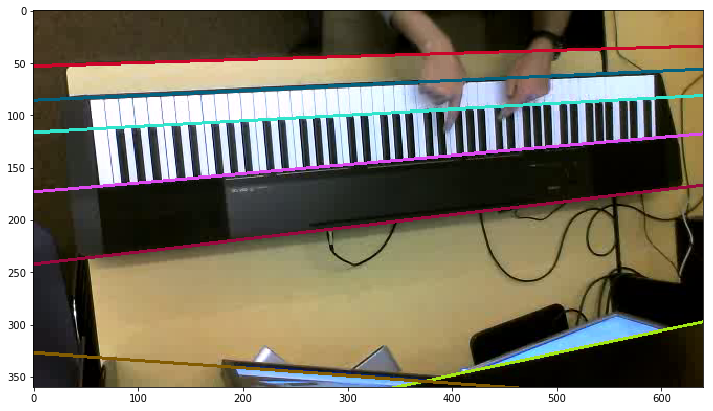

In [9]:
# Put filtered lines on the original image

display_lines(origin_file, unique_lines, 'stage_6.jpg')
# display_lines(frame, unique_lines, cv2.COLOR_GRAY2RGB)